# Steps Analysis (02/17/17 - 10/24/18)

In [126]:
from main_clean_function import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
df = main_clean_function('./data/export.xml')

In [128]:
df.columns

Index(['start_date', 'start_time', 'end_date', 'end_time', 'num_steps',
       'duration', 'source'],
      dtype='object')

In [163]:
def create_daily_steps_df(df):
    daily_df = df.groupby(by=['start_date', 'end_date']).sum()
#     daily_df['steps_per_hour'] = daily_df['num_steps']/summed_df['duration']
    daily_df.drop(columns=['start_time', 'end_time', 'duration'], inplace=True)
    daily_df.reset_index(inplace=True)
    return daily_df    

In [164]:
summed_df = create_daily_steps_df(df)

In [165]:
summed_df.head()

,start_date,end_date,num_steps
0,2017-02-17,2017-02-17,812.0
1,2017-02-18,2017-02-18,2668.0
2,2017-02-19,2017-02-19,2991.0
3,2017-02-20,2017-02-20,2812.0
4,2017-02-21,2017-02-21,2819.0


In [166]:
def drop_change_rename_df(df, x, col_rnm):
    df.drop(df.index[list(range(x-1))], inplace=True)
    df.reset_index(inplace=True)
#     df.drop(columns=['index'], inplace=True)
    df.loc[:, 'start_date'] = df['end_date'] - pd.Timedelta(x, unit='D')
    df.rename(columns={'num_steps': col_rnm+'num_steps'}, inplace=True)

    df.drop(columns=['index'], inplace=True)
    df.set_index(['start_date', 'end_date'], inplace=True)
    return df

In [167]:
def rolling_day_df(df, x):
    df.set_index(['start_date', 'end_date'], inplace=True)
    m_df = df.rolling(x).mean()
    m_df.reset_index(inplace=True)
    md_df = df.rolling(x).median()
    md_df.reset_index(inplace=True)
    std_df = df.rolling(x).std()
    std_df.reset_index(inplace=True)
    s_df = df.rolling(x).sum()
    s_df.reset_index(inplace=True)
#     min_df = df.rolling(x).min()
#     min_df.reset_index(inplace=True)
#     max_df = df.rolling(x).max()
#     max_df.reset_index(inplace=True)

    m_df = drop_change_rename_df(m_df, x, 'mean_')
    md_df = drop_change_rename_df(md_df, x, 'median_')
    std_df = drop_change_rename_df(std_df, x, 'std_')
    s_df = drop_change_rename_df(s_df, x, 'total_')
#     min_df = drop_change_rename_df(s_df, x, 'min_')
#     max_df = drop_change_rename_df(s_df, x, 'max_')
    
    merged_df_uno = pd.merge(m_df, md_df, on=m_df.index)
    merged_df_dos = pd.merge(std_df, s_df, on=std_df.index)
    merged_df_finale = pd.merge(merged_df_uno, merged_df_dos, on=merged_df_uno.index)
    merged_df_finale.drop(columns=['key_0_y'], inplace=True)
    merged_df_finale['steps_score_mean'] = merged_df_finale['mean_num_steps']/merged_df_finale['std_num_steps']
    merged_df_finale['steps_score_median'] = merged_df_finale['median_num_steps']/merged_df_finale['std_num_steps']
    merged_df_finale.reset_index(inplace=True)
    return merged_df_finale

In [176]:
roll_trenta = rolling_day_df(summed_df, 7)
summed_df.reset_index(inplace=True)
summed_df.drop(columns=['index'], inplace=True)

In [177]:
summed_df.reset_index(inplace=True)
summed_df.drop(columns=['index'], inplace=True)
summed_df.groupby(summed_df['start_date'].dt.strftime('%b%y'), sort=False).mean()

,num_steps
start_date,
Feb17,2813.666667
Mar17,3263.129032
Apr17,3880.266667
May17,3285.774194
Jun17,6418.233333
Jul17,5750.516129
Aug17,4210.096774
Sep17,5991.379310
Oct17,7442.451613


In [178]:
summed_df

,start_date,end_date,num_steps
0,2017-02-17,2017-02-17,812.0
1,2017-02-18,2017-02-18,2668.0
2,2017-02-19,2017-02-19,2991.0
3,2017-02-20,2017-02-20,2812.0
4,2017-02-21,2017-02-21,2819.0
5,2017-02-22,2017-02-22,2559.0
6,2017-02-23,2017-02-23,4396.0
7,2017-02-24,2017-02-24,3060.0
8,2017-02-25,2017-02-25,5439.0
9,2017-02-26,2017-02-26,1592.0


In [179]:
summed_df.num_steps.std()

3417.714769297332

In [180]:
print_remainder(df)

Total Rows = 24900
Total Steps = 4316358.0
start_date != end_date: 0


In [181]:
X = summed_df.start_date.values
y = df.num_steps.values
type(y)

numpy.ndarray

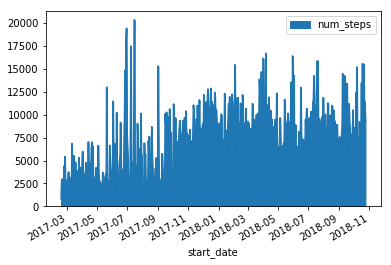

In [182]:
summed_df.plot(x='start_date', y='num_steps', kind='area')

In [185]:
summed_df

,start_date,end_date,num_steps
0,2017-02-17,2017-02-17,812.0
1,2017-02-18,2017-02-18,2668.0
2,2017-02-19,2017-02-19,2991.0
3,2017-02-20,2017-02-20,2812.0
4,2017-02-21,2017-02-21,2819.0
5,2017-02-22,2017-02-22,2559.0
6,2017-02-23,2017-02-23,4396.0
7,2017-02-24,2017-02-24,3060.0
8,2017-02-25,2017-02-25,5439.0
9,2017-02-26,2017-02-26,1592.0
